Yesterday, I read this [recent article on medium about facial keypoint detection](https://medium.com/towards-data-science/detecting-facial-features-using-deep-learning-2e23c8660a7a). The article suggests that deep learning methods can easily be used to perform this task. It ends by suggesting that everyone should try it, since the data needed and the toolkits are all open source. This article is my attempt, since I've been interested in face detection for a long time and [written about it before](http://flothesof.github.io/smile-recognition.html).

This is the outline of what we'll try:

- loading the data
- analyzing the data
- building a Keras model
- checking the results
- applying the method to a fun problem 

# Loading the data 

The data we will use comes from a [Kaggle challenge](https://www.kaggle.com/c/facial-keypoints-detection#description) called *Facial Keypoints Detection*. I've downloaded the *.csv* file and put it in a *data/* directory. Let's use pandas to read it.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/training.csv')

In [3]:
df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [4]:
df.shape

(7049, 31)

# Analyzing the data 

The `Image` column contains the face data for which the 30 first columns represent the keypoint data (15 x-coordinates and 15 y-coordinates). Let's try to get a feel for the data. First, let's display some faces.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
def string2image(string):
    """Converts a string to a numpy array."""
    return np.array([int(item) for item in string.split()]).reshape((96, 96))

def plot_faces(nrows=5, ncols=5):
    """Randomly displays some faces from the training data."""
    selection = np.random.choice(df.index, size=(nrows*ncols), replace=False)
    image_strings = df.loc[selection]['Image']
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for string, ax in zip(image_strings, axes.ravel()):
        ax.imshow(string2image(string), cmap='gray')
        ax.axis('off')

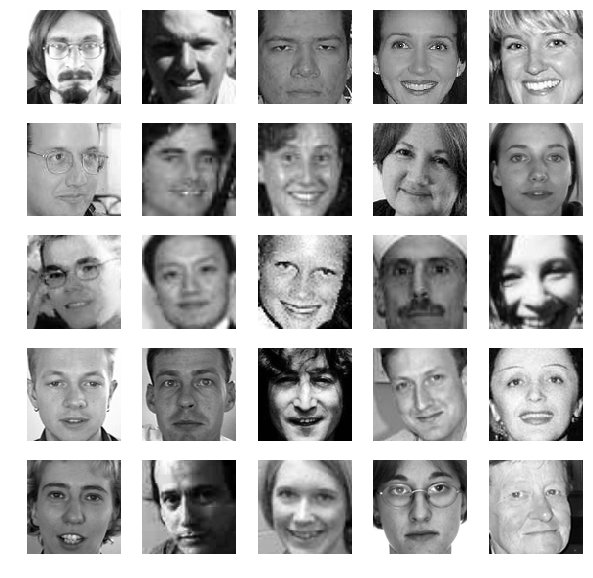

In [7]:
plot_faces()

Let's now add to that plot the facial keypoints that were tagged. First, let's do an example :

In [8]:
keypoint_cols = list(df.columns)[:-1]

In [9]:
xy = df.iloc[0][keypoint_cols].values.reshape((15, 2))
xy 

array([[66.033563909799994, 39.002273684199999],
       [30.227007518800001, 36.4216781955],
       [59.582075188000005, 39.647422556399995],
       [73.130345864700004, 39.9699969925],
       [36.356571428599999, 37.389401503800002],
       [23.452872180500002, 37.389401503800002],
       [56.953263157899997, 29.033648120300001],
       [80.227127819499998, 32.2281383459],
       [40.227609022599999, 29.002321804499999],
       [16.3563789474, 29.647470676699999],
       [44.420571428599999, 57.066803007499999],
       [61.195308270699996, 79.970165413499998],
       [28.614496240600001, 77.388992481199992],
       [43.312601503800003, 72.935458646599997],
       [43.130706766899998, 84.485774436100002]], dtype=object)

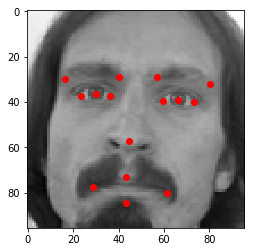

In [10]:
plt.plot(xy[:, 0], xy[:, 1], 'ro')
plt.imshow(string2image(df.iloc[0]['Image']), cmap='gray')

Now, let's add this to the function we wrote before.

In [11]:
def plot_faces_with_keypoints(nrows=5, ncols=5):
    """Randomly displays some faces from the training data with their keypoints."""
    selection = np.random.choice(df.index, size=(nrows*ncols), replace=False)
    image_strings = df.loc[selection]['Image']
    keypoint_cols = list(df.columns)[:-1]
    keypoints = df.loc[selection][keypoint_cols]
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for string, (iloc, keypoint), ax in zip(image_strings, keypoints.iterrows(), axes.ravel()):
        xy = keypoint.values.reshape((15, 2))
        ax.imshow(string2image(string), cmap='gray')
        ax.plot(xy[:, 0], xy[:, 1], 'ro')
        ax.axis('off')

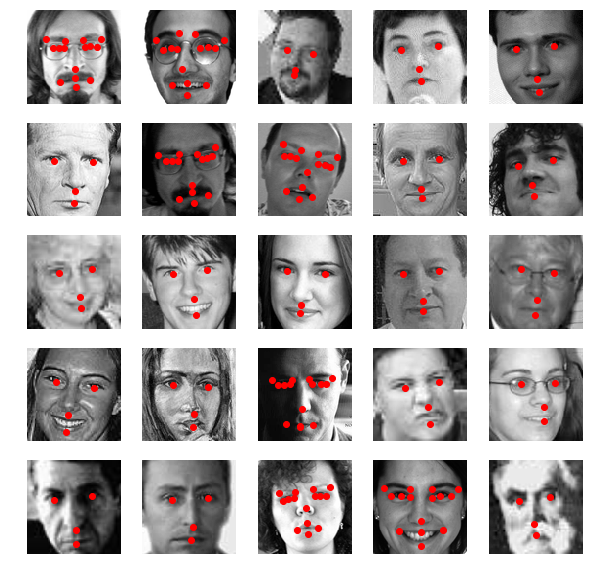

In [12]:
plot_faces_with_keypoints()

We can make several observations from this image: 

- some images are high resolution, some are low
- some images have all 15 keypoints, while some have only a few

Let's do some statistics about the keypoints to investigate that last observation :

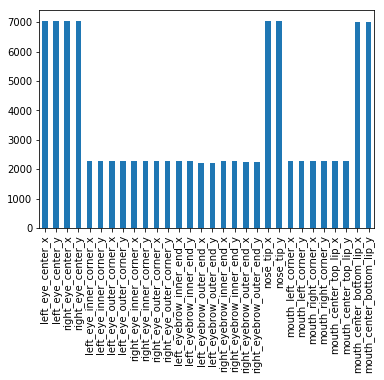

In [13]:
df.describe().loc['count'].plot.bar()

What this plot tells us is that in this dataset, only 2000 images are "high quality" with all keypoints, while 5000 other images are "low quality" with only 4 keypoints labelled.

Let's start training the data with the high quality images and see how far we get.

In [14]:
fully_annotated = df.dropna()

In [15]:
fully_annotated.shape

(2140, 31)

# Building a Keras model 

Now on to the machine learning part. Let's build a Keras model with our data. Actually, before we do that, let's do some preprocessing first, using the scikit-learn pipelines (inspired by [this great post on scalable Machine Learning by Tom Augspurger](https://tomaugspurger.github.io/scalable-ml-01.html)).

The idea behind pipelining is that it allows you to easily keep track of the data transformations applied to our data. We need two scalings: one for the input and one for the output. Since I couldn't get the scaling to work for 3d image data, we will only use a pipeline for our outputs.

In [16]:
X = np.stack([string2image(string) for string in fully_annotated['Image']]).astype(np.float)[:, :, :, np.newaxis]

In [17]:
y = np.vstack(fully_annotated[fully_annotated.columns[:-1]].values)

In [30]:
X.shape, X.dtype

((2140, 96, 96, 1), dtype('float64'))

In [31]:
y.shape, y.dtype

((2140, 30), dtype('float64'))

In [32]:
X_train = X / 255.

In [33]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1))
)

y_train = output_pipe.fit_transform(y)

In this case, the pipelining process is, how to say this, not very spectacular. Let's move on and train a Keras model! We will start with a simple model, as found [in this blog post](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/) with a fully connected layer and 100 hidden units.

In [34]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, GlobalAveragePooling2D

In [44]:
model = Sequential()
model.add(Dense(100, activation="relu", input_shape=(96*96,)))
model.add(Activation('relu'))
model.add(Dense(30))

Now let's compile the model and run the training.

In [47]:
from keras import optimizers

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 200
history = model.fit(X_train.reshape(y_train.shape[0], -1), y_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=20)

Train on 1712 samples, validate on 428 samples
Epoch 1/200
1712/1712 [==============================] - 1s - loss: 0.0173 - acc: 0.4836 - val_loss: 0.0542 - val_acc: 0.0794
Epoch 2/200
1712/1712 [==============================] - 1s - loss: 0.0170 - acc: 0.4842 - val_loss: 0.0554 - val_acc: 0.0911
Epoch 3/200
1712/1712 [==============================] - 1s - loss: 0.0167 - acc: 0.4842 - val_loss: 0.0546 - val_acc: 0.0888
Epoch 4/200
1712/1712 [==============================] - ETA: 0s - loss: 0.0165 - acc: 0.478 - 1s - loss: 0.0165 - acc: 0.4772 - val_loss: 0.0531 - val_acc: 0.1262
Epoch 5/200
1712/1712 [==============================] - 1s - loss: 0.0161 - acc: 0.4959 - val_loss: 0.0623 - val_acc: 0.0864
Epoch 6/200
1712/1712 [==============================] - 1s - loss: 0.0159 - acc: 0.4813 - val_loss: 0.0523 - val_acc: 0.1075
Epoch 7/200
1712/1712 [==============================] - 1s - loss: 0.0157 - acc: 0.4942 - val_loss: 0.0526 - val_acc: 0.1145
Epoch 8/200
1712/1712 [==========

1712/1712 [==============================] - 1s - loss: 0.0083 - acc: 0.5356 - val_loss: 0.0484 - val_acc: 0.1939
Epoch 129/200
1712/1712 [==============================] - 1s - loss: 0.0081 - acc: 0.5380 - val_loss: 0.0526 - val_acc: 0.1659
Epoch 130/200
1712/1712 [==============================] - 1s - loss: 0.0083 - acc: 0.5409 - val_loss: 0.0484 - val_acc: 0.1589
Epoch 131/200
1712/1712 [==============================] - 1s - loss: 0.0081 - acc: 0.5491 - val_loss: 0.0494 - val_acc: 0.1425
Epoch 132/200
1712/1712 [==============================] - 1s - loss: 0.0081 - acc: 0.5473 - val_loss: 0.0487 - val_acc: 0.1706
Epoch 133/200
1712/1712 [==============================] - 1s - loss: 0.0082 - acc: 0.5508 - val_loss: 0.0508 - val_acc: 0.1636
Epoch 134/200
1712/1712 [==============================] - 1s - loss: 0.0081 - acc: 0.5643 - val_loss: 0.0525 - val_acc: 0.1542
Epoch 135/200
1712/1712 [==============================] - 1s - loss: 0.0082 - acc: 0.5403 - val_loss: 0.0495 - val_ac

Let's plot our training curves with this model.

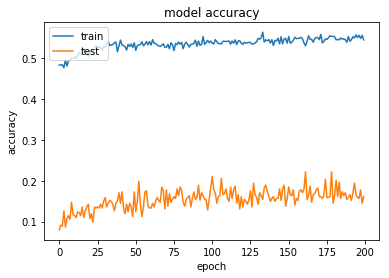

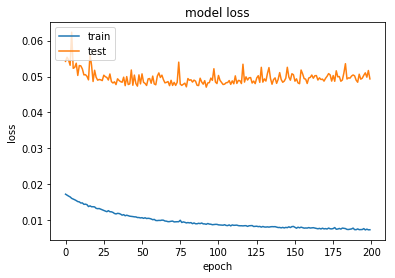

In [48]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

What we see here is that with this model, the learning quickly gets on a plateau. How can we improve this? There are a lot of options:

- adjust the optimizer settings
    - learning rate
    - batch size
    - momentum
- change the model

However, one things that is pretty clear from the above plot is that our model overfits: the train and test losses are not comparable (the test loss is 3 times higher). Let's see what the results of the net are on some samples from our data.

In [84]:
img = X_train[0, :, :, :].reshape(1, -1)
predictions = model.predict(img)

In [85]:
img

array([[ 0.93333333,  0.9254902 ,  0.92941176, ...,  0.2745098 ,
         0.29411765,  0.35294118]])

In [87]:
xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)

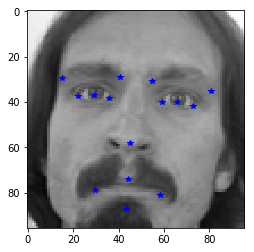

In [88]:
plt.imshow(X_train[0, :, :, 0], cmap='gray')
plt.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'b*')

In [111]:
def plot_faces_with_keypoints_and_predictions(model, nrows=5, ncols=5, model_input='flat'):
    """Plots sampled faces with their truth and predictions."""
    selection = np.random.choice(np.arange(X.shape[0]), size=(nrows*ncols), replace=False)
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for ind, ax in zip(selection, axes.ravel()):
        img = X_train[ind, :, :, 0]
        if model_input == 'flat':
            predictions = model.predict(img.reshape(1, -1))
        else:
            predictions = model.predict(img[np.newaxis, :, :, np.newaxis])
        xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)
        ax.imshow(img, cmap='gray')
        ax.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'bo')
        ax.axis('off')

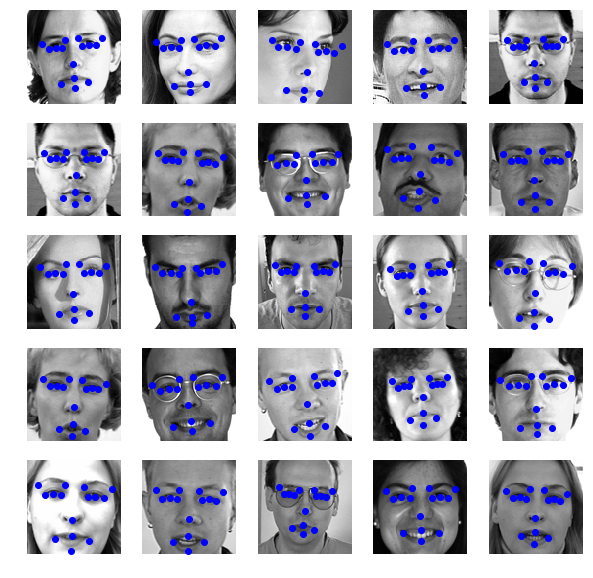

In [96]:
plot_faces_with_keypoints_and_predictions(model)

Actually, this looks pretty good already. Let's try to train a more complicated model, this time following the initial model description found in Peter Skvarenina's article.

# Towards more complicated models 

In [114]:
from keras.layers import Dropout, Flatten

In [115]:
model = Sequential()
# input layer
model.add(BatchNormalization(input_shape=(96, 96, 1)))
model.add(Conv2D(24, (5, 5), kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 2
model.add(Conv2D(36, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 3
model.add(Conv2D(48, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 4
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))
# layer 5
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
# layer 6
model.add(Dense(500, activation="relu"))
# layer 7
model.add(Dense(90, activation="relu"))
# layer 8
model.add(Dense(30))

In [117]:
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.95, nesterov=True)
model.compile(optimizer=sgd, loss='mse', metrics=['accuracy'])
epochs = 50
history = model.fit(X_train, y_train, 
                 validation_split=0.2, shuffle=True, 
                 epochs=epochs, batch_size=20)

Train on 1712 samples, validate on 428 samples
Epoch 1/50
1712/1712 [==============================] - 36s - loss: 0.0261 - acc: 0.4112 - val_loss: 0.0544 - val_acc: 0.1332
Epoch 2/50
1712/1712 [==============================] - 35s - loss: 0.0219 - acc: 0.4282 - val_loss: 0.0485 - val_acc: 0.1519
Epoch 3/50
1712/1712 [==============================] - 39s - loss: 0.0198 - acc: 0.4445 - val_loss: 0.0447 - val_acc: 0.1402
Epoch 4/50
1712/1712 [==============================] - 38s - loss: 0.0181 - acc: 0.4609 - val_loss: 0.0426 - val_acc: 0.1449
Epoch 5/50
1712/1712 [==============================] - 37s - loss: 0.0167 - acc: 0.4609 - val_loss: 0.0410 - val_acc: 0.1706
Epoch 6/50
1712/1712 [==============================] - 37s - loss: 0.0156 - acc: 0.4918 - val_loss: 0.0417 - val_acc: 0.1565
Epoch 7/50
1712/1712 [==============================] - 36s - loss: 0.0144 - acc: 0.4912 - val_loss: 0.0389 - val_acc: 0.1589
Epoch 8/50
1712/1712 [==============================] - 36s - loss: 0.0

Let's see that in curves: 

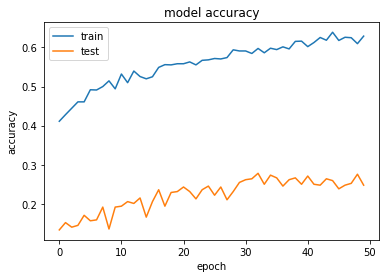

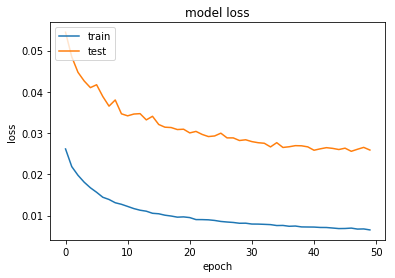

In [118]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

How good is the result?

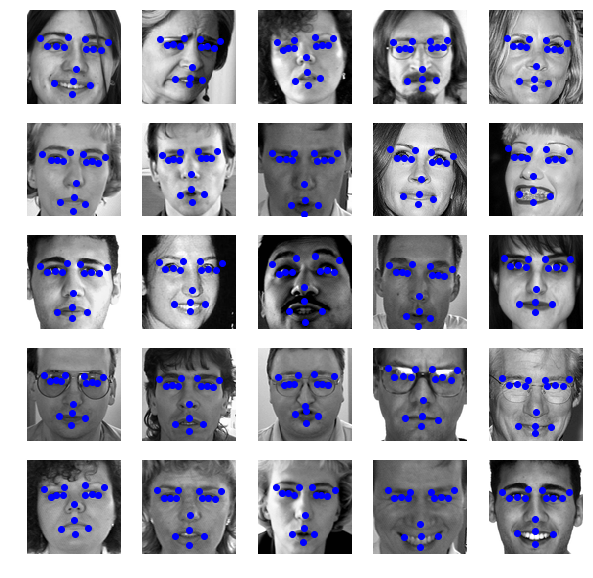

In [120]:
plot_faces_with_keypoints_and_predictions(model, model_input='2d')

If you ask me, that's already pretty good. Even though we didn't reach the performance advertised in Peter Skvarenina's blog post, with 80% validation accuracy. I wonder what he used to reach that level of performance: longer training? better settings? 

Let's move on to the last section of this blog post: applications.

# Applications 

## A face mask 

A first thing we can do is to apply some sort of mask on top of the detected image. Let's draw a moustache over an image for example. 

First, we need an image of a moustache.

In [175]:
import skimage.color
from skimage.filters import median

In [337]:
moustache = plt.imread('http://www.freeiconspng.com/uploads/moustache-png-by-spoonswagging-on-deviantart-1.png')
moustache = skimage.color.rgb2gray(moustache)

In [338]:
moustache = median(moustache, selem=np.ones((3, 3)))

/Users/kappamaki/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Let's display it.

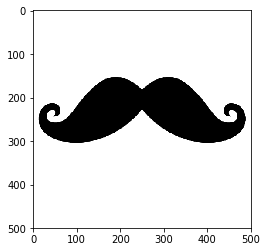

In [339]:
plt.imshow(moustache, cmap='gray')

Now, let's extract the boundary of this moustache.

In [340]:
from skimage import measure
moustache_contour = measure.find_contours(moustache, 0.8)[0]
moustache_contour -= np.array([250, 250])

Now, let's write a function that plots a scaled moustache at a given position.

In [368]:
def plot_scaled_moustache(ax, center_xy, dx):
    """Plots a moustache scaled by its width, dx, on current ax."""
    moustache_scaled = moustache_contour.copy()
    moustache_scaled -= moustache_contour.min(axis=0)
    moustache_scaled /= moustache_scaled.max(axis=0)[1]
    deltas = moustache_scaled.max(axis=0) - moustache_scaled.min(axis=0)
    moustache_scaled -= np.array([deltas[0]/2, deltas[1]/2])
    moustache_scaled *= dx
    moustache_scaled += center_xy[::-1]
    ax.fill(moustache_scaled[:, 1], moustache_scaled[:, 0], "g", linewidth=4)

Let's test this:

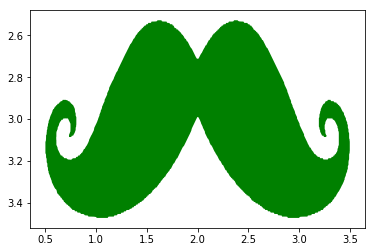

In [369]:
ax = plt.gca()
plot_scaled_moustache(ax, np.array([2, 3]), dx=3)
ax.invert_yaxis()

Finally, we can integrate this with a function of the predicted points. We will use the mouth location and space the moustache using the size of the mouth.

In [370]:
def draw_moustache(predicted_points, ax):
    """Draws a moustache using the predicted face points."""
    dx = 2 * np.linalg.norm(predicted_points[12, :] - predicted_points[11, :])
    center_xy = predicted_points[13, :]
    plot_scaled_moustache(ax, center_xy, dx)

Let's try this with the first image from the training set.

In [371]:
img = X_train[0, :, :, :][np.newaxis, :, :, :]
predictions = model.predict(img)
xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)

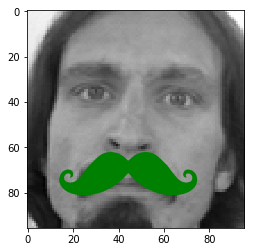

In [372]:
fig, ax = plt.subplots()
ax.imshow(X_train[0, :, :, 0], cmap='gray')
draw_moustache(xy_predictions, ax)

Ok, looks good. Let's apply this to a grid of images.

In [373]:
def plot_faces_with_moustaches(model, nrows=5, ncols=5, model_input='flat'):
    """Plots sampled faces with their truth and predictions."""
    selection = np.random.choice(np.arange(X.shape[0]), size=(nrows*ncols), replace=False)
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for ind, ax in zip(selection, axes.ravel()):
        img = X_train[ind, :, :, 0]
        if model_input == 'flat':
            predictions = model.predict(img.reshape(1, -1))
        else:
            predictions = model.predict(img[np.newaxis, :, :, np.newaxis])
        xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)
        ax.imshow(img, cmap='gray')
        draw_moustache(xy_predictions, ax)
        ax.axis('off')

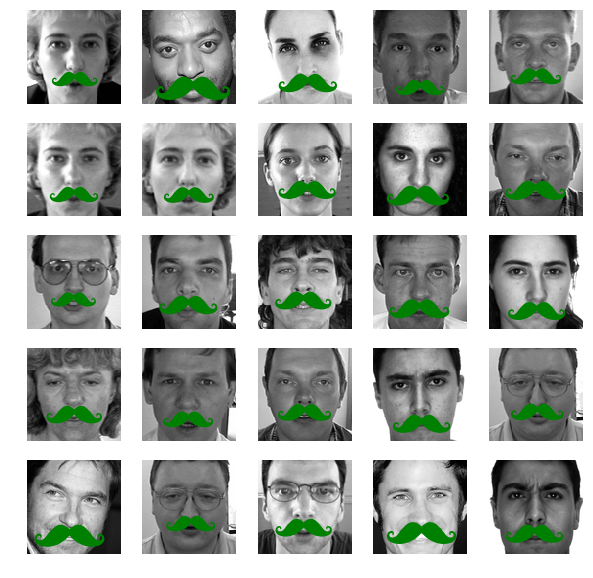

In [375]:
plot_faces_with_moustaches(model, model_input='2d')

This is fun. There's a couple of ways we could better: adjust for face directions (the tilted faces in particular look strange). But that's already pretty nice. Let's make a gallery of famous faces with moustaches.

## Famous faces with moustaches 

Let's apply the skill of adding automated moustaches to some famous paintings.

In [501]:
portrait_urls = ["https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/1024px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg",
                "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Hans_Holbein%2C_the_Younger_-_Sir_Thomas_More_-_Google_Art_Project.jpg/1280px-Hans_Holbein%2C_the_Younger_-_Sir_Thomas_More_-_Google_Art_Project.jpg",
                "https://upload.wikimedia.org/wikipedia/commons/b/b6/The_Blue_Boy.jpg",
                "https://upload.wikimedia.org/wikipedia/commons/thumb/2/2f/Thomas_Kerrich_%281748-1828%29%2C_by_Pompeo_Batoni.jpg/1280px-Thomas_Kerrich_%281748-1828%29%2C_by_Pompeo_Batoni.jpg",
                "https://upload.wikimedia.org/wikipedia/en/d/d6/GertrudeStein.JPG",
                "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Ambrogio_de_Predis_-_Girl_with_Cherries.jpg/1024px-Ambrogio_de_Predis_-_Girl_with_Cherries.jpg",
                "https://upload.wikimedia.org/wikipedia/commons/f/f8/Martin_Luther%2C_1529.jpg",
                "https://upload.wikimedia.org/wikipedia/commons/thumb/6/60/Pierre-Auguste_Renoir_110.jpg/1280px-Pierre-Auguste_Renoir_110.jpg"]

In [502]:
portraits = {}
for url in portrait_urls:
    if url not in portraits:
        portraits[url] = imread(url)

In [503]:
from skimage.io import imread
import cv2

/Users/kappamaki/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


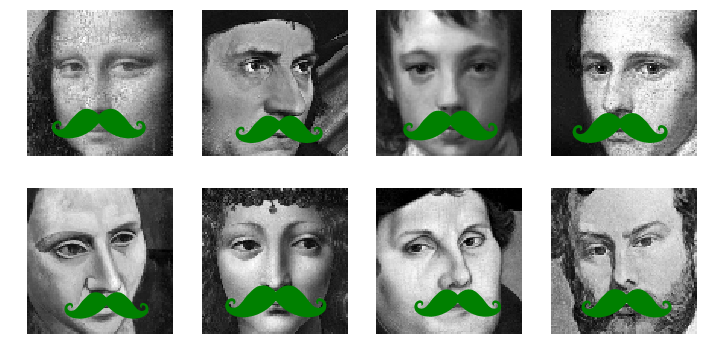

In [505]:
face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
for img, ax in zip(portraits.values(), axes.ravel()):
    gray = (skimage.color.rgb2gray(img) * 255).astype(dtype='uint8')
    bounding_boxes = face_cascade.detectMultiScale(gray, 1.25, 6)
    for (x,y,w,h) in bounding_boxes:
        roi_gray = gray[y:y+h, x:x+w]
        roi_rescaled = skimage.transform.resize(roi_gray, (96, 96))
        predictions = model.predict(roi_rescaled[np.newaxis, :, :, np.newaxis])
        xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)
        ax.imshow(roi_rescaled, cmap='gray')
        draw_moustache(xy_predictions, ax)
    ax.axis('off')

For comparison's sake, here are the original paintings:

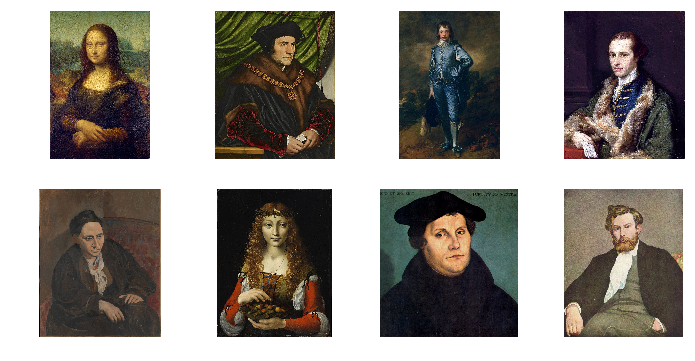

In [506]:
face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
for img, ax in zip(portraits.values(), axes.ravel()):
    ax.imshow(img)
    ax.axis('off')

# Conclusions 

Okay, that's it for this blog post. So what steps did we go through? We trained a model using Kaggle data, Keras and a deep convolutional neural network. The model was good enough that we could apply it to images from the internet without major changes. 

After doing all this, I still feel that we only scratched the edge of what we could do with this. In particular, the neural network part was not very satisfying since I feel the model we trained could have been better. The reason I did not delve deeper into this (no pun intended) is that I don't own any GPU and hence the training takes quite a long time, which I was not willing to wait for better results. 

As a takeaway from this post, I think the claim that a high school genius could do things like these on his own is indeed true. If you have the data, it seems that the machine learning models are powerful and simple enough to allow you to do things that were much more complicated in the past. 

If I have time for a next post, I'd love to extend the work we did here but do transfer learning, using features from famous already trained neural networks.

*This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20170914_FacialKeypointsDetection.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20170914_FacialKeypointsDetection.ipynb).*